# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [24]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
interestRate = pd.read_csv('../data/interestRate.csv')

In [25]:
train_data['type'] = "train"
test_data['type'] = "test"
df = pd.concat([train_data, test_data], axis = 0)
df.drop(['index'], axis = 1, inplace = True)
df = df.merge(interestRate, left_on='contract_year_month', right_on='year_month', how='left')
df.drop(columns=['year_month'], inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951400 entries, 0 to 1951399
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   area_m2              float64
 1   contract_year_month  int64  
 2   contract_day         int64  
 3   contract_type        int64  
 4   floor                int64  
 5   built_year           int64  
 6   latitude             float64
 7   longitude            float64
 8   age                  int64  
 9   deposit              float64
 10  type                 object 
 11  interest_rate        float64
dtypes: float64(5), int64(6), object(1)
memory usage: 178.7+ MB


In [27]:
df.describe()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate
count,1.951400e+06,1.951400e+06,1.951400e+06,1.951400e+06,1.951400e+06,1.951400e+06,1.951400e+06,1.951400e+06,1.951400e+06,1.801228e+06,1.939518e+06
mean,7.513613e+01,2.021539e+05,1.581610e+01,1.143954e+00,1.005263e+01,2.004253e+03,3.747700e+01,1.269663e+02,1.722186e+01,3.816223e+04,2.260255e+00
std,2.541068e+01,1.485655e+02,8.624062e+00,8.909771e-01,6.974086e+00,1.117700e+01,1.628588e-01,1.702728e-01,1.116694e+01,2.610377e+04,1.206402e+00
min,1.032150e+01,2.019040e+05,1.000000e+00,0.000000e+00,-4.000000e+00,1.961000e+03,3.691791e+01,1.264787e+02,-3.000000e+00,3.000000e+02,8.000000e-01
25%,5.975500e+01,2.020090e+05,8.000000e+00,0.000000e+00,5.000000e+00,1.995000e+03,3.737858e+01,1.268422e+02,7.000000e+00,2.100000e+04,1.160000e+00
50%,7.695000e+01,2.022010e+05,1.600000e+01,1.000000e+00,9.000000e+00,2.004000e+03,3.750222e+01,1.269976e+02,1.700000e+01,3.200000e+04,1.720000e+00
75%,8.496000e+01,2.023030e+05,2.300000e+01,2.000000e+00,1.400000e+01,2.015000e+03,3.758282e+01,1.270890e+02,2.600000e+01,4.780000e+04,3.560000e+00
max,3.173600e+02,2.024060e+05,3.100000e+01,2.000000e+00,6.800000e+01,2.024000e+03,3.818194e+01,1.276609e+02,6.200000e+01,1.100000e+06,4.340000e+00


In [28]:
def train_valid_test_split(df):
    # 데이터 분할
    train_data = df[df['type'] == 'train']
    test_data = df[df['type'] == 'test']

    valid_start = 202307
    valid_end = 202312

    valid_data = train_data[(train_data['contract_year_month'] >= valid_start) & (train_data['contract_year_month'] <= valid_end)]
    train_data = train_data[~((train_data['contract_year_month'] >= valid_start) & (train_data['contract_year_month'] <= valid_end))]

    return train_data, valid_data, test_data

In [29]:
train_data, valid_data, test_data = train_valid_test_split(df)

/tmp/ipykernel_160684/2174744111.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', k)
/data/ephemeral/home/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


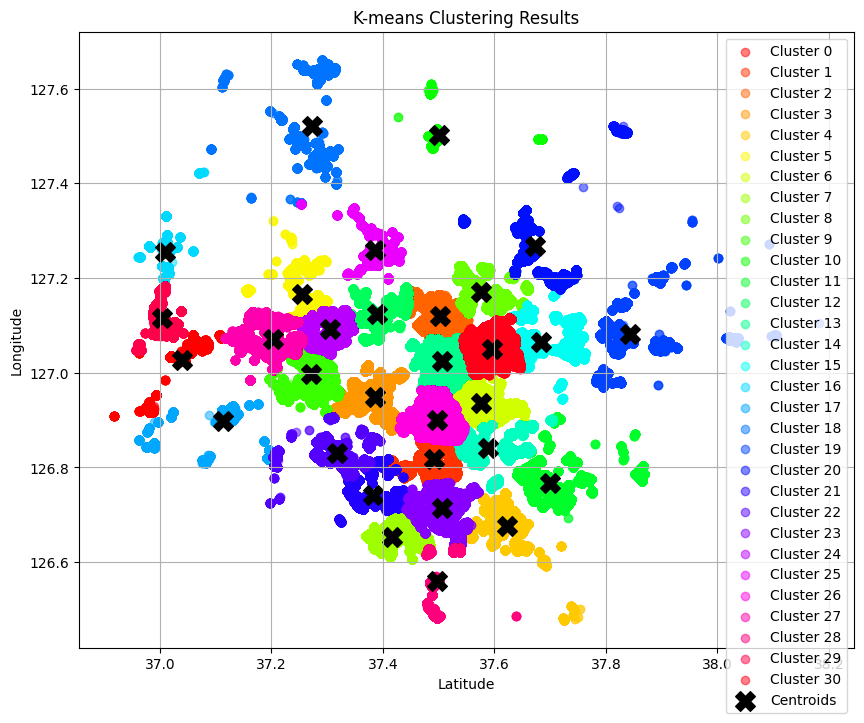

In [30]:
from sklearn.cluster import KMeans

# K-means 클러스터링
k = 31  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=k, random_state=42)
train_data['cluster'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])

# 클러스터 시각화
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('hsv', k)

for i in range(k):
    cluster_data = train_data[train_data['cluster'] == i]
    plt.scatter(cluster_data['latitude'], cluster_data['longitude'],
                color=colors(i), label=f'Cluster {i}', alpha=0.5)

# 중심점 시각화
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='X', s=200, label='Centroids')

plt.title('K-means Clustering Results')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.grid()
plt.show()

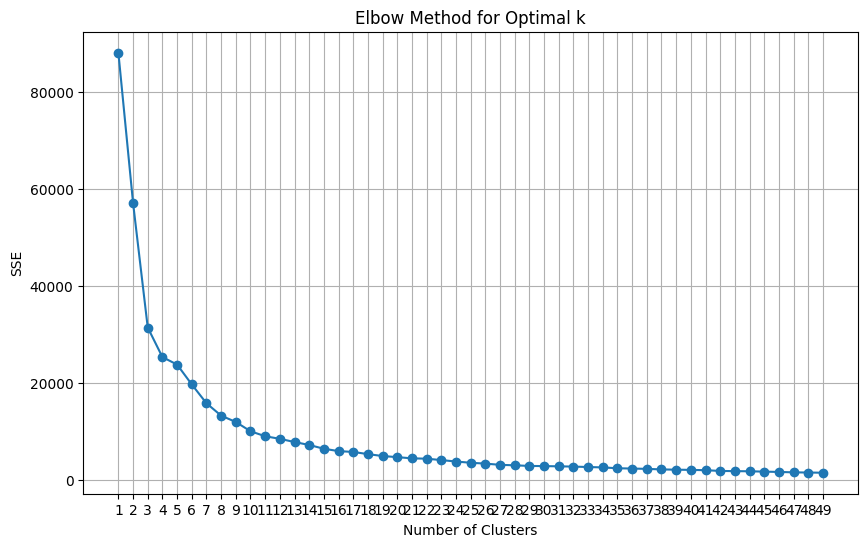

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 클러스터 수에 따른 SSE 계산
sse = []
cluster_range = range(1, 50)  # 1부터 30까지의 클러스터 수

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(train_data[['latitude', 'longitude']])  # 클러스터링할 피처 선택
    sse.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [33]:
from sklearn.cluster import KMeans

def create_cluster_density(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # 클러스터별 밀도 계산 (클러스터별 포인트 수)
    cluster_density = train_data.groupby('cluster').size().reset_index(name='density')

    train_data = train_data.merge(cluster_density, on='cluster', how='left')
    valid_data = valid_data.merge(cluster_density, on='cluster', how='left')
    test_data = test_data.merge(cluster_density, on='cluster', how='left')

    return train_data, valid_data, test_data

def create_cluster_distance_to_centroid(data: pd.DataFrame, centroids) -> pd.DataFrame:
    # 포함되는 군집의 centroid와의 거리 계산
    lat_centroids = np.array([centroids[cluster, 0] for cluster in data['cluster']])
    lon_centroids = np.array([centroids[cluster, 1] for cluster in data['cluster']])
    lat_diff = data['latitude'].values - lat_centroids
    lon_diff = data['longitude'].values - lon_centroids
    data['distance_to_centroid'] = np.sqrt(lat_diff ** 2 + lon_diff ** 2)
    return data

def create_cluster_deposit_mean(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    cluster_means = train_data.groupby('cluster')['deposit'].mean().reset_index()
    cluster_means.columns = ['cluster', 'deposit_mean']

    train_data = train_data.merge(cluster_means, on='cluster', how='left')
    valid_data = valid_data.merge(cluster_means, on='cluster', how='left')
    test_data = test_data.merge(cluster_means, on='cluster', how='left')

    return train_data, valid_data, test_data

def create_clustering_target(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # K-means 클러스터링
    k = 31
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    train_data['cluster'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])
    valid_data['cluster'] = kmeans.predict(valid_data[['latitude', 'longitude']])
    test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
    
    train_data['cluster'] = train_data['cluster'].astype('category')
    valid_data['cluster'] = valid_data['cluster'].astype('category')
    test_data['cluster'] = test_data['cluster'].astype('category')

    # 군집 밀도 변수 추가
    train_data, valid_data, test_data = create_cluster_density(train_data, valid_data, test_data)
    train_data, valid_data, test_data = create_cluster_deposit_mean(train_data, valid_data, test_data)

    centroids = kmeans.cluster_centers_

    # 군집 centroid까지의 거리 변수 추가
    train_data = create_cluster_distance_to_centroid(train_data, centroids)
    valid_data = create_cluster_distance_to_centroid(valid_data, centroids)
    test_data = create_cluster_distance_to_centroid(test_data, centroids)

    return train_data, valid_data, test_data

In [34]:
train_data, valid_data, test_data = create_clustering_target(train_data, valid_data, test_data)

/tmp/ipykernel_160684/2956436444.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/tmp/ipykernel_160684/2956436444.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/tmp/ipykernel_160684/2956436444.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

In [35]:
import pandas as pd
from sklearn.neighbors import KDTree

subwayInfo = pd.read_csv("../data/subwayInfo.csv")

# KD-트리 생성
subway_coords = subwayInfo[['latitude', 'longitude']].values
tree = KDTree(subway_coords, leaf_size=10)

# 거리 계산 함수 정의
def add_nearest_subway_distance(data):
    # 각 집의 좌표 가져오기
    house_coords = data[['latitude', 'longitude']].values
    # 가장 가까운 지하철 역까지의 거리 계산
    distances, indices = tree.query(house_coords, k=1)  # k=1: 가장 가까운 역
    # 거리를 데이터프레임에 추가 (미터 단위로 변환)
    data['nearest_subway_distance'] = distances.flatten()
    return data

# 각 데이터셋에 대해 거리 추가
train_data = add_nearest_subway_distance(train_data)
valid_data = add_nearest_subway_distance(valid_data)
test_data = add_nearest_subway_distance(test_data)

# 결과 확인
print(train_data.head())
print(valid_data.head())
print(test_data.head())

   area_m2  contract_year_month  contract_day  contract_type  floor  \
0  84.9981               201906            25              2      9   
1  84.9981               202003            26              2     20   
2  84.9981               202003            28              2      8   
3  59.3400               201907            15              2      1   
4  59.8100               201904            12              2      6   

   built_year   latitude   longitude  age  deposit   type  interest_rate  \
0        2019  37.054314  127.045216    0  17000.0  train           1.78   
1        2019  37.054314  127.045216    1  23000.0  train           1.26   
2        2019  37.054314  127.045216    1  23000.0  train           1.26   
3        1986  36.964647  127.055847   33   5000.0  train           1.68   
4        1995  36.972390  127.084514   24   1800.0  train           1.85   

  cluster  density  deposit_mean  distance_to_centroid  \
0       0    11805  17813.484202              0.023320   


In [36]:
import pandas as pd
from sklearn.neighbors import KDTree

# subwayInfo에는 지하철 역의 위도와 경도가 포함되어 있다고 가정
subwayInfo = pd.read_csv("../data/subwayInfo.csv")
subway_coords = subwayInfo[['latitude', 'longitude']].values
tree = KDTree(subway_coords, leaf_size=10)

def count_subways_within_radius(data, radius):
    counts = []  # 초기화
    # 10,000개씩 배치로 처리
    for i in range(0, len(data), 10000):
        batch = data.iloc[i:i+10000]
        house_coords = batch[['latitude', 'longitude']].values
        # KDTree를 사용하여 주어진 반경 내 지하철역 찾기
        indices = tree.query_radius(house_coords, r=radius)  # 반경에 대한 인덱스
        # 각 집의 주변 지하철역 개수 세기
        counts.extend(len(idx) for idx in indices)

    # counts의 길이가 data와 동일해야 함
    # counts가 데이터프레임 크기보다 작을 경우 0으로 채우기
    if len(counts) < len(data):
        counts.extend([0] * (len(data) - len(counts)))
    
    # 데이터프레임에 결과 추가
    data['subways_within_radius'] = counts
    return data

# 각 데이터셋에 대해 거리 추가 (예: 반경 100미터)
radius = 0.01  # 약 1km
train_data = count_subways_within_radius(train_data, radius)
valid_data = count_subways_within_radius(valid_data, radius)
test_data = count_subways_within_radius(test_data, radius)

# 결과 확인
print(train_data[['latitude', 'longitude', 'subways_within_radius']].head())
print(valid_data[['latitude', 'longitude', 'subways_within_radius']].head())
print(test_data[['latitude', 'longitude', 'subways_within_radius']].head())


    latitude   longitude  subways_within_radius
0  37.054314  127.045216                      1
1  37.054314  127.045216                      1
2  37.054314  127.045216                      1
3  36.964647  127.055847                      0
4  36.972390  127.084514                      0
    latitude   longitude  subways_within_radius
0  37.200075  126.820401                      0
1  37.200075  126.820401                      0
2  37.200075  126.820401                      0
3  37.200075  126.820401                      0
4  37.200075  126.820401                      0
    latitude   longitude  subways_within_radius
0  36.965423  127.048779                      0
1  36.963105  127.040678                      0
2  36.957089  127.047449                      0
3  36.957089  127.047449                      0
4  36.957089  127.047449                      0


In [37]:
train_data.describe()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate,density,deposit_mean,distance_to_centroid,nearest_subway_distance,subways_within_radius
count,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06,1.594362e+06
mean,7.508859e+01,2.021102e+05,1.593594e+01,1.286510e+00,1.002655e+01,2.004104e+03,3.747751e+01,1.269655e+02,1.693582e+01,3.781473e+04,1.940824e+00,7.228475e+04,3.781473e+04,3.695970e-02,1.457634e-02,1.464639e+00
std,2.561507e+01,1.269527e+02,8.642991e+00,8.676945e-01,6.952118e+00,1.109581e+01,1.621779e-01,1.702499e-01,1.106617e+01,2.575919e+04,1.091806e+00,2.780225e+04,1.528549e+04,2.011691e-02,2.201984e-02,1.697569e+00
min,1.032150e+01,2.019040e+05,1.000000e+00,0.000000e+00,-4.000000e+00,1.961000e+03,3.691791e+01,1.264787e+02,-3.000000e+00,3.000000e+02,8.000000e-01,1.660000e+03,1.312671e+04,3.555798e-04,2.908519e-04,0.000000e+00
25%,5.973500e+01,2.020060e+05,9.000000e+00,0.000000e+00,5.000000e+00,1.995000e+03,3.738018e+01,1.268411e+02,7.000000e+00,2.100000e+04,9.500000e-01,5.265500e+04,2.660543e+04,2.385332e-02,4.438612e-03,0.000000e+00
50%,7.679000e+01,2.021080e+05,1.600000e+01,2.000000e+00,9.000000e+00,2.004000e+03,3.750246e+01,1.269947e+02,1.700000e+01,3.200000e+04,1.630000e+00,7.611500e+04,3.504512e+04,3.512755e-02,7.405943e-03,1.000000e+00
75%,8.496000e+01,2.022070e+05,2.300000e+01,2.000000e+00,1.400000e+01,2.014000e+03,3.758190e+01,1.270885e+02,2.600000e+01,4.700000e+04,2.900000e+00,9.982300e+04,4.437887e+04,4.632544e-02,1.441473e-02,2.000000e+00
max,3.173600e+02,2.023060e+05,3.100000e+01,2.000000e+00,6.800000e+01,2.024000e+03,3.818194e+01,1.276609e+02,6.200000e+01,1.100000e+06,4.340000e+00,1.186270e+05,8.024675e+04,3.388836e-01,2.560213e-01,1.200000e+01


In [38]:
train_data = train_data.drop(columns=['type'])
valid_data = valid_data.drop(columns=['type'])
test_data = test_data.drop(columns=['type'])

In [39]:
def split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled):
    X_train = train_data_scaled.drop(columns=['deposit'])
    y_train = train_data_scaled['deposit']
    X_valid = valid_data_scaled.drop(columns=['deposit'])
    y_valid = valid_data_scaled['deposit']
    X_test = test_data_scaled.drop(columns=['deposit'])
    
    return X_train, y_train, X_valid, y_valid, X_test

In [40]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

X_train, y_train, X_valid, y_valid, X_test = split_feature_target(train_data, valid_data, test_data)

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

lgb_valid_pred = lgb_model.predict(X_valid)
lgb_valid_mae = mean_absolute_error(y_valid, lgb_valid_pred)
print("valid 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_valid_mae:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 1594362, number of used features: 16
[LightGBM] [Info] Start training from score 37814.733261
valid 데이터셋 성능:
LightGBM MAE: 6217.14


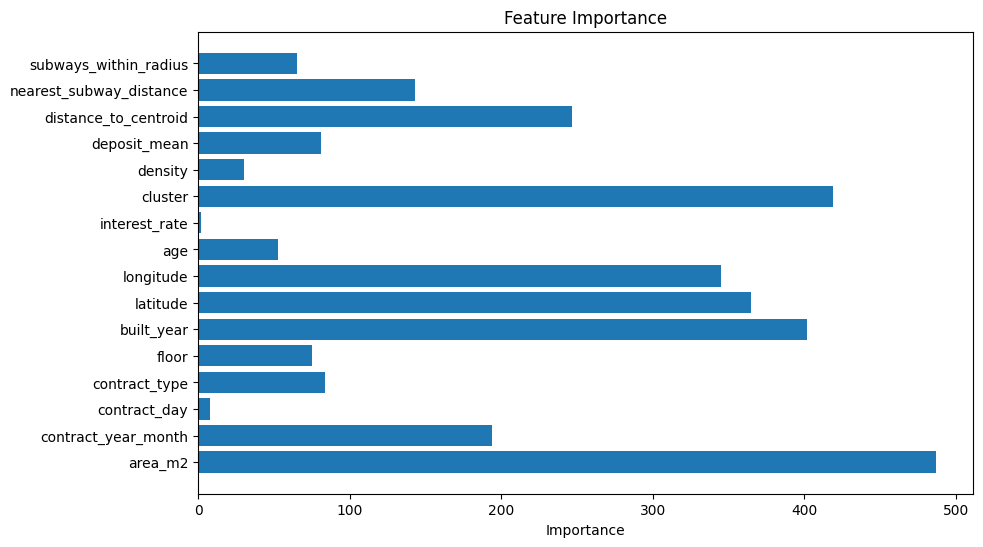

In [41]:
# 피처 중요도 얻기
importance = lgb_model.feature_importances_

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importance)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [42]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')

In [22]:
X_train.T

,0,1,2,3,4,5,6,7,8,9,...,1594352,1594353,1594354,1594355,1594356,1594357,1594358,1594359,1594360,1594361
area_m2,84.998100,84.998100,84.998100,59.340000,59.810000,84.934200,39.270000,84.934200,84.961000,84.918200,...,114.928500,95.958000,115.510100,115.510100,115.510100,115.510100,101.908800,115.510100,115.510100,115.510100
contract_year_month,201906.000000,202003.000000,202003.000000,201907.000000,201904.000000,201904.000000,201905.000000,201905.000000,201905.000000,201905.000000,...,202305.000000,202306.000000,202306.000000,202306.000000,202306.000000,202306.000000,202306.000000,202306.000000,202306.000000,202306.000000
contract_day,25.000000,26.000000,28.000000,15.000000,12.000000,26.000000,7.000000,9.000000,25.000000,25.000000,...,30.000000,7.000000,10.000000,10.000000,10.000000,10.000000,10.000000,17.000000,27.000000,28.000000
contract_type,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
floor,9.000000,20.000000,8.000000,1.000000,6.000000,13.000000,3.000000,3.000000,3.000000,13.000000,...,4.000000,10.000000,11.000000,11.000000,19.000000,19.000000,5.000000,19.000000,15.000000,3.000000
built_year,2019.000000,2019.000000,2019.000000,1986.000000,1995.000000,2016.000000,1990.000000,2016.000000,2016.000000,2016.000000,...,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000
latitude,37.054314,37.054314,37.054314,36.964647,36.972390,36.965423,36.957089,36.965423,36.965423,36.965423,...,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394
longitude,127.045216,127.045216,127.045216,127.055847,127.084514,127.048779,127.047449,127.048779,127.048779,127.048779,...,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398
age,0.000000,1.000000,1.000000,33.000000,24.000000,3.000000,29.000000,3.000000,3.000000,3.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
interest_rate,1.780000,1.260000,1.260000,1.680000,1.850000,1.850000,1.850000,1.850000,1.850000,1.850000,...,3.560000,3.700000,3.700000,3.700000,3.700000,3.700000,3.700000,3.700000,3.700000,3.700000


In [23]:
X_test.T

,0,1,2,3,4,5,6,7,8,9,...,150162,150163,150164,150165,150166,150167,150168,150169,150170,150171
area_m2,84.961000,59.900000,39.270000,39.270000,46.980000,84.918200,80.987900,59.970000,59.970000,59.970000,...,142.873800,142.873800,114.928500,114.790000,114.009100,115.510100,142.873800,142.873800,114.928500,115.510100
contract_year_month,202404.000000,202404.000000,202404.000000,202405.000000,202406.000000,202406.000000,202404.000000,202404.000000,202404.000000,202404.000000,...,202402.000000,202402.000000,202402.000000,202402.000000,202402.000000,202402.000000,202403.000000,202403.000000,202403.000000,202403.000000
contract_day,12.000000,13.000000,29.000000,3.000000,2.000000,14.000000,2.000000,3.000000,11.000000,13.000000,...,1.000000,1.000000,2.000000,19.000000,23.000000,27.000000,2.000000,16.000000,22.000000,22.000000
contract_type,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
floor,14.000000,4.000000,5.000000,1.000000,4.000000,13.000000,2.000000,4.000000,5.000000,4.000000,...,1.000000,1.000000,10.000000,19.000000,17.000000,17.000000,4.000000,13.000000,2.000000,7.000000
built_year,2016.000000,1997.000000,1990.000000,1990.000000,1990.000000,2016.000000,2005.000000,2002.000000,2002.000000,2002.000000,...,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000
latitude,36.965423,36.963105,36.957089,36.957089,36.957089,36.965423,36.960034,36.963650,36.963650,36.963650,...,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394,37.528394
longitude,127.048779,127.040678,127.047449,127.047449,127.047449,127.048779,127.059939,127.060117,127.060117,127.060117,...,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398,126.659398
age,8.000000,27.000000,34.000000,34.000000,34.000000,8.000000,19.000000,22.000000,22.000000,22.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
deposit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.linear_model import LinearRegression

# X와 y 설정
X = train_data[['distance_to_centroid']].values  # 2D 배열
y = train_data['deposit'].values

# 선형 회귀 모델 생성
model = LinearRegression()
model.fit(X, y)

# 예측값 계산
y_pred = model.predict(X)

# 회귀 계수와 절편 출력
slope = model.coef_[0]
intercept = model.intercept_

print(f'Coefficient (Slope): {slope:.2f}')
print(f'Intercept: {intercept:.2f}')

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(train_data['distance_to_centroid'], train_data['deposit'], alpha=0.7, label='Data Points')
plt.plot(train_data['distance_to_centroid'], y_pred, color='red', label='Regression Line')
plt.title('Distance to Centroid vs Deposit with Regression Line')
plt.xlabel('Distance to Centroid')
plt.ylabel('Deposit')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 잔차 계산
residuals = y - y_pred

# 잔차 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()